**Write a custom ResNet architecture for CIFAR10 that has the following architecture:**

**PrepLayer - Conv 3x3 s1, p1) >> BN >> RELU [64k]**

**Layer1 -
X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [128k]
R1 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [128k] 
Add(X, R1)**

**Layer 2 -
Conv 3x3 [256k]
MaxPooling2D
BN
ReLU**

**Layer 3 -
X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [512k]
R2 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [512k]
Add(X, R2)**

**MaxPooling with Kernel Size 4**

**FC Layer**

**SoftMax**

**Uses One Cycle Policy such that:

Total Epochs = 24

Max at Epoch = 5

LRMIN = FIND

LRMAX = FIND

NO Annihilation

Uses this transform -RandomCrop 32, 32 (after padding of 4) >> FlipLR >> Followed by CutOut(8, 8)

Batch size = 512**

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np 
from models.resnet import *
from utils import *
from main import *
from onecycle import *
!pip install torchsummary
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Loading test and train datasets & dataloader**

In [2]:
# Loading test and train data & dataloader
cifar10 = dataset_cifar10(batch_size=512)

trainset = cifar10.data(train_flag=True)

testset =  cifar10.data(train_flag=False)
# load Train dataloader
trainloader = cifar10.loader(train_flag=True)

# Load Test dataloader
testloader = cifar10.loader(train_flag=False)

# Get all the classes
classes = cifar10.classes


CUDA availability ? True
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Import Model

In [3]:
# Loading ResNet18 Model
model = ResNet()
# Using cuda if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
# Sending network to device
model = model.to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
         ResBlock-14          [-1,

#Creating instance of all the 3 Models by passing Normalization Type as a Parameter

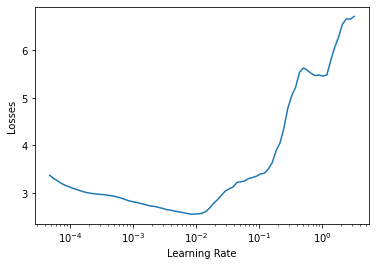

In [4]:
from clr import *
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
clr = CLR(optimizer, len(trainloader),1e-5,10)
calculate_lr(model , optimizer, trainloader , criterion, clr, device)
clr.plot()

# Calling the Model with 24 Epochs

In [7]:
from torch.optim.lr_scheduler import OneCycleLR

EPOCHS = 24
bs = 512
torch.autograd.set_detect_anomaly(True)
model =  ResNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.077, momentum=0.9)
l1reg = False
# calculate the total number of steps
total_steps = len(trainloader) * 24

# calculate the step size for the first 5 epochs
step_size_up = len(trainloader) * 5
scheduler = OneCycleLR(optimizer, max_lr=0.077, total_steps=total_steps, pct_start=step_size_up/total_steps, anneal_strategy='cos', cycle_momentum=False)

train_loss, test_loss, train_acc, test_acc , test_pred, target_pred, target_data = main(EPOCHS, model, device, trainloader, testloader, optimizer, criterion, scheduler, l1reg)



Epoch 0 : 
Train set: Average loss: 1.4403, Accuracy: 41.00

Test set: Average loss: 0.004, Accuracy: 41.30

Epoch 1 : 
Train set: Average loss: 1.2742, Accuracy: 48.88

Test set: Average loss: 0.003, Accuracy: 53.71

Epoch 2 : 
Train set: Average loss: 1.3152, Accuracy: 60.43

Test set: Average loss: 0.002, Accuracy: 61.22

Epoch 3 : 
Train set: Average loss: 0.8507, Accuracy: 63.69

Test set: Average loss: 0.002, Accuracy: 71.81

Epoch 4 : 
Train set: Average loss: 0.8564, Accuracy: 73.83

Test set: Average loss: 0.001, Accuracy: 76.79

Epoch 5 : 
Train set: Average loss: 0.7402, Accuracy: 77.91

Test set: Average loss: 0.002, Accuracy: 75.58

Epoch 6 : 
Train set: Average loss: 0.4352, Accuracy: 80.57

Test set: Average loss: 0.001, Accuracy: 81.34

Epoch 7 : 
Train set: Average loss: 0.3789, Accuracy: 83.87

Test set: Average loss: 0.001, Accuracy: 82.24

Epoch 8 : 
Train set: Average loss: 0.2953, Accuracy: 86.83

Test set: Average loss: 0.001, Accuracy: 85.68

Epoch 9 : 
Train s